Установить и импортировать необходимые зависимости

In [2]:
!pip install matplotlib torch torchvision datasets
!pip install "cleanlab[image]"
# We install cleanlab with extra dependencies for image data
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install "cleanlab[image] @ git+https://github.com/cleanlab/cleanlab.git"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.5/285.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 29.4 MB/s eta 0:00:00


In [3]:
# Package installation (this cell is hidden from docs.cleanlab.ai).
# If running on Colab, may want to use GPU (select: Runtime > Change runtime type > Hardware accelerator > GPU)

dependencies = ["cleanlab", "matplotlib", "torch", "torchvision", "datasets", "cleanvision"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install "cleanlab[image]"  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

# Suppress benign warnings:
import warnings
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

In [4]:
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import math
import time
import multiprocessing

from cleanlab import Datalab
from datasets import load_dataset

Получить и нормализовать набор данных

In [5]:
dataset = load_dataset("fashion_mnist", split="train")
dataset

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [6]:
num_classes = len(dataset.features["label"].names)
num_classes

10

In [8]:
# Convert PIL image to torch tensors
transformed_dataset = dataset.with_format("torch")
# Apply transformations
def normalize(example):
    example["image"] = (example["image"] / 255.0).unsqueeze(0)
    return example


transformed_dataset = transformed_dataset.map(normalize, num_proc=multiprocessing.cpu_count())

Map (num_proc=2):   0%|          | 0/60000 [00:00<?, ? examples/s]

In [9]:
torch_dataset = TensorDataset(transformed_dataset["image"], transformed_dataset["label"])

 Определить модель классификации

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
        )
        self.linear = nn.Sequential(nn.LazyLinear(128), nn.ReLU())
        self.output = nn.Sequential(nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.embeddings(x)
        x = self.output(x)
        return x

    def embeddings(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.linear(x)
        return x

In [11]:
# This (optional) cell is hidden from docs.cleanlab.ai

SEED = 123  # for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.cuda.manual_seed_all(SEED)

In [12]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Method to calculate validation accuracy in each epoch
def get_test_accuracy(net, testloader):
    net.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)

            # run the model on the test set to predict labels
            outputs = net(images)

            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


# Method for training the model
def train(trainloader, testloader, n_epochs, patience):
    model = Net()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters())

    model = model.to(device)

    best_test_accuracy = 0.0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        start_epoch = time.time()
        running_loss = 0.0

        for _, data in enumerate(trainloader):
            # get the inputs; data is a dict of {"image": images, "label": labels}

            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.detach().cpu().item()

        # Get accuracy on the test set
        accuracy = get_test_accuracy(model, testloader)

        if accuracy > best_test_accuracy:
            best_epoch = epoch

        # Condition for early stopping
        if epoch - best_epoch > patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        end_epoch = time.time()

        print(
            f"epoch: {epoch + 1} loss: {running_loss / len(trainloader):.3f} test acc: {accuracy:.3f} time_taken: {end_epoch - start_epoch:.3f}"
        )
    return model


# Method for computing out-of-sample embeddings
def compute_embeddings(model, testloader):
    embeddings_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)

            embeddings = model.embeddings(images)
            embeddings_list.append(embeddings.cpu())

    return torch.vstack(embeddings_list)


# Method for computing out-of-sample predicted probabilities
def compute_pred_probs(model, testloader):
    pred_probs_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)

            outputs = model(images)
            pred_probs_list.append(outputs.cpu())

    return torch.vstack(pred_probs_list)

Подготовить набор данных для перекрестной проверки в K-кратном размере.

In [13]:
K = 3  # Количество сверток перекрестной проверки. Установите здесь небольшое значение, чтобы обеспечить быстрое время выполнения. На практике мы рекомендуем 5 или 10 для более точных оценок.
n_epochs = 2  # Количество эпох для обучения модели. Установите здесь небольшое значение для быстрого выполнения, на практике вам следует использовать большее значение.
patience = 2  # Параметр для быстрой остановки. Если точность проверки не улучшится в течение этого количества эпох, обучение остановится.
train_batch_size = 64  # Размер пакета для обучения
test_batch_size = 512  # Размер пакета для тестирования
num_workers = multiprocessing.cpu_count()  # Number of workers for data loaders

# Create k splits of the dataset
kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
splits = kfold.split(transformed_dataset, transformed_dataset["label"])

train_id_list, test_id_list = [], []

for fold, (train_ids, test_ids) in enumerate(splits):
    train_id_list.append(train_ids)
    test_id_list.append(test_ids)

Вычисление предсказанных вероятности вне выборки и встраивания признаков

In [14]:
pred_probs_list, embeddings_list = [], []
embeddings_model = None

for i in range(K):
    print(f"\nTraining on fold: {i+1} ...")

    # Create train and test sets and corresponding dataloaders
    trainset = Subset(torch_dataset, train_id_list[i])
    testset = Subset(torch_dataset, test_id_list[i])

    trainloader = DataLoader(
        trainset,
        batch_size=train_batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    testloader = DataLoader(
        testset, batch_size=test_batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )

    # Train model
    model = train(trainloader, testloader, n_epochs, patience)
    if embeddings_model is None:
        embeddings_model = model

    # Compute out-of-sample embeddings
    print("Computing feature embeddings ...")
    fold_embeddings = compute_embeddings(embeddings_model, testloader)
    embeddings_list.append(fold_embeddings)

    print("Computing predicted probabilities ...")
    # Compute out-of-sample predicted probabilities
    fold_pred_probs = compute_pred_probs(model, testloader)
    pred_probs_list.append(fold_pred_probs)

print("Finished Training")


# Combine embeddings and predicted probabilities from each fold
features = torch.vstack(embeddings_list).numpy()

logits = torch.vstack(pred_probs_list)
pred_probs = nn.Softmax(dim=1)(logits).numpy()


Training on fold: 1 ...
epoch: 1 loss: 0.482 test acc: 86.840 time_taken: 16.635
epoch: 2 loss: 0.328 test acc: 88.245 time_taken: 15.161
Computing feature embeddings ...


100%|██████████| 40/40 [00:04<00:00,  9.06it/s]


Computing predicted probabilities ...


100%|██████████| 40/40 [00:03<00:00, 10.74it/s]



Training on fold: 2 ...
epoch: 1 loss: 0.492 test acc: 87.035 time_taken: 15.067
epoch: 2 loss: 0.330 test acc: 88.495 time_taken: 14.839
Computing feature embeddings ...


100%|██████████| 40/40 [00:03<00:00, 12.33it/s]


Computing predicted probabilities ...


100%|██████████| 40/40 [00:02<00:00, 15.79it/s]


Training on fold: 3 ...


epoch: 1 loss: 0.476 test acc: 86.400 time_taken: 18.541
epoch: 2 loss: 0.328 test acc: 86.930 time_taken: 14.719
Computing feature embeddings ...


100%|██████████| 40/40 [00:02<00:00, 17.55it/s]


Computing predicted probabilities ...


100%|██████████| 40/40 [00:02<00:00, 17.00it/s]

Finished Training


In [15]:
indices = np.hstack(test_id_list)
dataset = dataset.select(indices)

 Cleanlab для поиска проблем

In [16]:
lab = Datalab(data=dataset, label_name="label", image_key="image")

In [17]:
lab.find_issues(features=features, pred_probs=pred_probs)

Finding label issues ...
Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding dark, light, low_information, odd_aspect_ratio, odd_size, grayscale, blurry images ...


  0%|          | 0/60000 [00:00<?, ?it/s]

Removing grayscale from potential issues in the dataset as it exceeds max_prevalence=0.1

Audit complete. 7378 issues found in the dataset.


Here is a summary of the different kinds of issues found in the data:

      issue_type  num_issues
           label        3500
         outlier        3472
  near_duplicate         224
 low_information         166
            dark          16
         non_iid           0
          blurry           0
           light           0
odd_aspect_ratio           0
        odd_size           0

Dataset Information: num_examples: 60000, num_classes: 10


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 3500
Overall dataset quality in terms of this issue: 0.9409

Examples representing most severe instances of this issue:
       is_label_issue  label_score given_label  predicted_label
11262            True     0.000003        Coat  T - shirt / top
21282            True     0.000016     

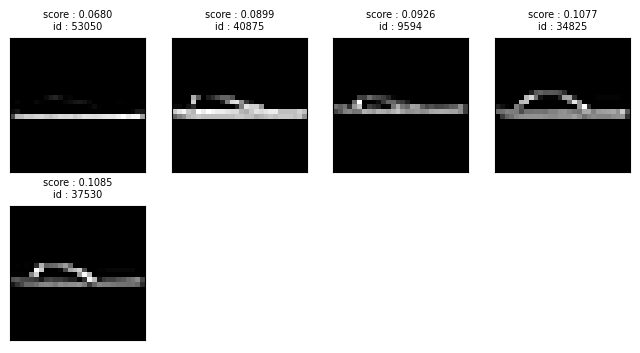

----------------------- dark images ------------------------

Number of examples with this issue: 16
Examples representing most severe instances of this issue:



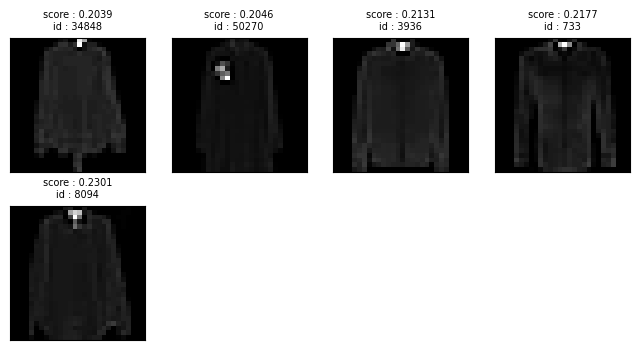

In [18]:
lab.report()

Проблемы с маркировкой

In [19]:
label_issues = lab.get_issues("label")
label_issues.head()

,is_label_issue,label_score,given_label,predicted_label
0,True,0.148178,T - shirt / top,Dress
1,False,0.987132,T - shirt / top,T - shirt / top
2,False,0.999157,Sandal,Sandal
3,False,0.967703,Sandal,Sandal
4,False,0.998973,Dress,Dress


In [20]:
label_issues_df = label_issues.query("is_label_issue").sort_values("label_score")
label_issues_df.head()

,is_label_issue,label_score,given_label,predicted_label
11262,True,0.000003,Coat,T - shirt / top
21282,True,0.000016,Bag,Dress
19228,True,0.000018,Dress,Shirt
54078,True,0.000022,Pullover,Dress
45386,True,0.000032,Coat,Trouser


In [21]:
def plot_label_issue_examples(label_issues_df, num_examples=15):
    ncols = 5
    nrows = int(math.ceil(num_examples / ncols))

    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()
    label_issue_indices = label_issues_df.index.values

    for i, ax in enumerate(axes_list):
        if i >= num_examples:
            ax.axis("off")
            continue
        idx = int(label_issue_indices[i])
        row = label_issues.loc[idx]
        ax.set_title(
            f"id: {idx}\n GL: {row.given_label}\n SL: {row.predicted_label}",
            fontdict={"fontsize": 8},
        )
        ax.imshow(dataset[idx]["image"], cmap="gray")
        ax.axis("off")
    plt.subplots_adjust(hspace=0.7)
    plt.show()

Просмотр наиболее вероятных примеров с ошибками в ярлыках

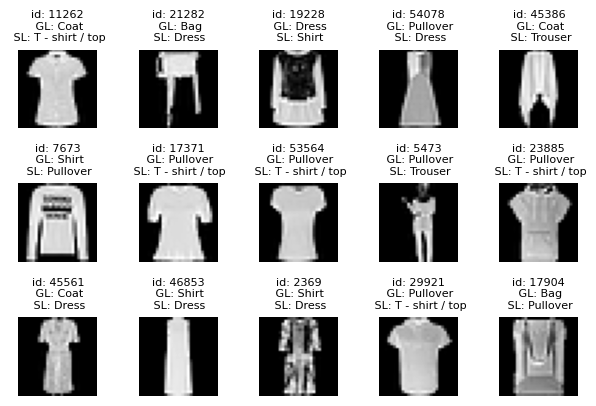

In [22]:
plot_label_issue_examples(label_issues_df, num_examples=15)

In [23]:
outlier_issues_df = lab.get_issues("outlier")
outlier_issues_df = outlier_issues_df.query("is_outlier_issue").sort_values("outlier_score")
outlier_issues_df.head()

,is_outlier_issue,outlier_score
27080,True,0.709767
40378,True,0.723273
54473,True,0.723336
30741,True,0.732847
25316,True,0.734628


Просмотр наиболее важных выбросов

In [24]:
def plot_outlier_issues_examples(outlier_issues_df, num_examples):
    ncols = 4
    nrows = num_examples
    N_comparison_images = ncols - 1

    def sample_from_class(label, number_of_samples, index):
        index = int(index)

        non_outlier_indices = (
            label_issues.join(outlier_issues_df)
            .query("given_label == @label and is_outlier_issue.isnull()")
            .index
        )
        non_outlier_indices_excluding_current = non_outlier_indices[non_outlier_indices != index]

        sampled_indices = np.random.choice(
            non_outlier_indices_excluding_current, number_of_samples, replace=False
        )

        label_scores_of_sampled = label_issues.loc[sampled_indices]["label_score"]

        top_score_indices = np.argsort(label_scores_of_sampled.values)[::-1][:N_comparison_images]

        top_label_indices = sampled_indices[top_score_indices]

        sampled_images = [dataset[int(i)]["image"] for i in top_label_indices]

        return sampled_images

    def get_image_given_label_and_samples(idx):
        image_from_dataset = dataset[idx]["image"]
        corresponding_label = label_issues.loc[idx]["given_label"]
        comparison_images = sample_from_class(corresponding_label, 30, idx)[:N_comparison_images]

        return image_from_dataset, corresponding_label, comparison_images

    count = 0
    images_to_plot = []
    labels = []
    idlist = []
    for idx, row in outlier_issues_df.iterrows():
        idx = row.name
        image, label, comparison_images = get_image_given_label_and_samples(idx)
        labels.append(label)
        idlist.append(idx)
        images_to_plot.append(image)
        images_to_plot.extend(comparison_images)
        count += 1
        if count >= nrows:
            break

    ncols = 1 + N_comparison_images
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()
    for i, ax in enumerate(axes_list):
        if i % ncols == 0:
            ax.set_title(
                f"id: {idlist[i // ncols]}\n GL: {labels[i // ncols]}", fontdict={"fontsize": 8}
            )
        ax.imshow(images_to_plot[i], cmap="gray")
        ax.axis("off")
    plt.subplots_adjust(hspace=0.7)
    plt.show()

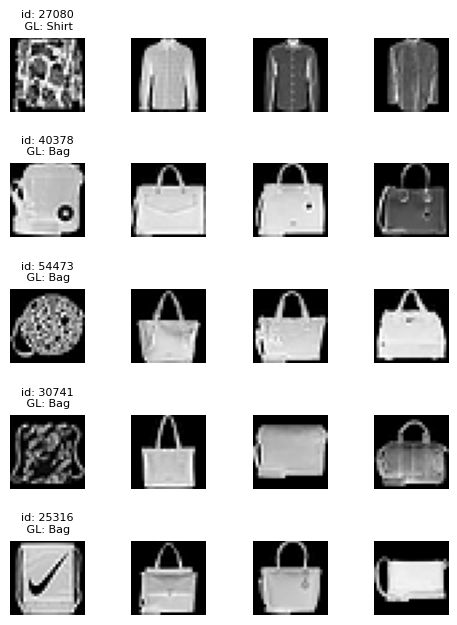

In [25]:
plot_outlier_issues_examples(outlier_issues_df, num_examples=5)

In [26]:
near_duplicate_issues_df = lab.get_issues("near_duplicate")
near_duplicate_issues_df = near_duplicate_issues_df.query("is_near_duplicate_issue").sort_values(
    "near_duplicate_score"
)
near_duplicate_issues_df.head()

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
9762,True,0.000018,"[258, 54565, 47139]",0.000018
258,True,0.000018,"[9762, 54565, 47139]",0.000018
30659,True,0.000023,[30968],0.000023
30968,True,0.000023,[30659],0.000023
47824,True,0.000026,[3370],0.000026


Просмотр наборов почти повторяющихся изображений

In [27]:
def plot_near_duplicate_issue_examples(near_duplicate_issues_df, num_examples=3):
    nrows = num_examples
    seen_id_pairs = set()

    def get_image_and_given_label_and_predicted_label(idx):
        image = dataset[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        return image, label, predicted_label

    count = 0
    for idx, row in near_duplicate_issues_df.iterrows():
        image, label, predicted_label = get_image_and_given_label_and_predicted_label(idx)
        duplicate_images = row.near_duplicate_sets
        nd_set = set([int(i) for i in duplicate_images])
        nd_set.add(int(idx))

        if nd_set & seen_id_pairs:
            continue

        _, axes = plt.subplots(1, len(nd_set), figsize=(len(nd_set), 3))
        for i, ax in zip(list(nd_set), axes):
            label = label_issues.loc[i]["given_label"]
            ax.set_title(f"id: {i}\n GL: {label}", fontdict={"fontsize": 8})
            ax.imshow(dataset[i]["image"], cmap="gray")
            ax.axis("off")
        seen_id_pairs.update(nd_set)
        count += 1
        if count >= nrows:
            break

    plt.show()

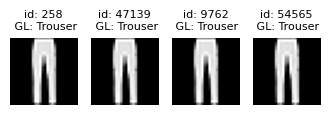

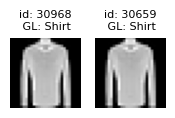

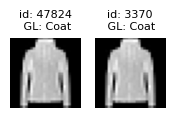

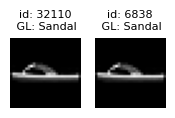

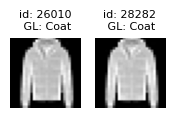

In [28]:
plot_near_duplicate_issue_examples(near_duplicate_issues_df, num_examples=5)

Темные изображения

In [29]:
dark_issues = lab.get_issues("dark")
dark_issues_df = dark_issues.query("is_dark_issue").sort_values("dark_score")
dark_issues_df.head()

,dark_score,is_dark_issue
34848,0.203922,True
50270,0.204588,True
3936,0.213098,True
733,0.217686,True
8094,0.230118,True


In [30]:
def plot_image_issue_examples(issues_df, num_examples=15):
    ncols = 5
    nrows = int(math.ceil(num_examples / ncols))

    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()
    issue_indices = issues_df.index.values

    for i, ax in enumerate(axes_list):
        if i >= num_examples:
            ax.axis("off")
            continue
        idx = int(issue_indices[i])
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        ax.set_title(
            f"id: {idx}\n GL: {label}\n SL: {predicted_label}",
            fontdict={"fontsize": 8},
        )
        ax.imshow(dataset[idx]["image"], cmap="gray")
        ax.axis("off")

    plt.subplots_adjust(hspace=0.7)
    plt.show()

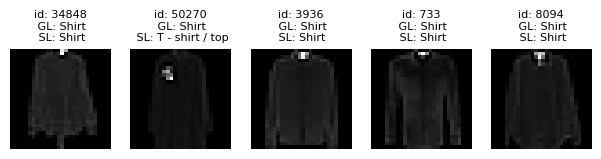

In [31]:
plot_image_issue_examples(dark_issues_df, num_examples=5)

In [32]:
lowinfo_issues = lab.get_issues("low_information")
lowinfo_issues_df = lowinfo_issues.query("is_low_information_issue").sort_values(
    "low_information_score"
)
lowinfo_issues_df.head()

,is_low_information_issue,low_information_score
53050,True,0.067975
40875,True,0.089929
9594,True,0.092601
34825,True,0.107744
37530,True,0.108516


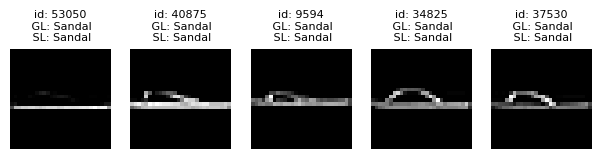

In [33]:
plot_image_issue_examples(lowinfo_issues_df, num_examples=5)

In [34]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

assert set([53050, 40875, 9594, 34825, 37530]).issubset(lowinfo_issues_df.index.values.tolist())
assert set([34848, 50270, 3936, 733, 8094]).issubset(dark_issues_df.index.values.tolist())
assert set([47824, 3370, 3952, 37119]).issubset(near_duplicate_issues_df.index.values.tolist())
assert set([38093, 22628, 44031, 25316, 40329]).issubset(outlier_issues_df.index.values.tolist())
assert set([45561, 11262, 54078, 53564]).issubset(label_issues_df.index.values.tolist())

Импорт другого датасета


In [37]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [39]:
def clean_data(df):

    drop_indices = []
    print('[INFO]: Checking if all images are present')
    for index, image_id in tqdm(df.iterrows()):
        if not os.path.exists(f"../input/fashion-product-images-small/images/{image_id.id}.jpg"):
            drop_indices.append(index)
    print(f"[INFO]: Dropping indices: {drop_indices}")
    df.drop(df.index[drop_indices], inplace=True)
    return df

In [41]:
num_classes = len(dataset.features["label"].names)
num_classes

10

In [42]:
# Convert PIL image to torch tensors
transformed_dataset = dataset.with_format("torch")


# Apply transformations
def normalize(example):
    example["image"] = (example["image"] / 255.0).unsqueeze(0)
    return example


transformed_dataset = transformed_dataset.map(normalize, num_proc=multiprocessing.cpu_count())

Map (num_proc=2):   0%|          | 0/60000 [00:00<?, ? examples/s]

In [43]:
torch_dataset = TensorDataset(transformed_dataset["image"], transformed_dataset["label"])

In [49]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
        )
        self.linear = nn.Sequential(nn.LazyLinear(128), nn.ReLU())
        self.output = nn.Sequential(nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.embeddings(x)
        x = self.output(x)
        return x

    def embeddings(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.linear(x)
        return x

In [50]:
# This (optional) cell is hidden from docs.cleanlab.ai

SEED = 123  # for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.cuda.manual_seed_all(SEED)

In [51]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Method to calculate validation accuracy in each epoch
def get_test_accuracy(net, testloader):
    net.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)

            # run the model on the test set to predict labels
            outputs = net(images)

            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


# Method for training the model
def train(trainloader, testloader, n_epochs, patience):
    model = Net()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters())

    model = model.to(device)

    best_test_accuracy = 0.0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        start_epoch = time.time()
        running_loss = 0.0

        for _, data in enumerate(trainloader):
            # get the inputs; data is a dict of {"image": images, "label": labels}

            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.detach().cpu().item()

        # Get accuracy on the test set
        accuracy = get_test_accuracy(model, testloader)

        if accuracy > best_test_accuracy:
            best_epoch = epoch

        # Condition for early stopping
        if epoch - best_epoch > patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        end_epoch = time.time()

        print(
            f"epoch: {epoch + 1} loss: {running_loss / len(trainloader):.3f} test acc: {accuracy:.3f} time_taken: {end_epoch - start_epoch:.3f}"
        )
    return model


# Method for computing out-of-sample embeddings
def compute_embeddings(model, testloader):
    embeddings_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)

            embeddings = model.embeddings(images)
            embeddings_list.append(embeddings.cpu())

    return torch.vstack(embeddings_list)


# Method for computing out-of-sample predicted probabilities
def compute_pred_probs(model, testloader):
    pred_probs_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)

            outputs = model(images)
            pred_probs_list.append(outputs.cpu())

    return torch.vstack(pred_probs_list)

In [52]:
# This (optional) cell is hidden from docs.cleanlab.ai

SEED = 123  # for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.cuda.manual_seed_all(SEED)

In [53]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Method to calculate validation accuracy in each epoch
def get_test_accuracy(net, testloader):
    net.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)

            # run the model on the test set to predict labels
            outputs = net(images)

            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


# Method for training the model
def train(trainloader, testloader, n_epochs, patience):
    model = Net()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters())

    model = model.to(device)

    best_test_accuracy = 0.0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        start_epoch = time.time()
        running_loss = 0.0

        for _, data in enumerate(trainloader):
            # get the inputs; data is a dict of {"image": images, "label": labels}

            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.detach().cpu().item()

        # Get accuracy on the test set
        accuracy = get_test_accuracy(model, testloader)

        if accuracy > best_test_accuracy:
            best_epoch = epoch

        # Condition for early stopping
        if epoch - best_epoch > patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        end_epoch = time.time()

        print(
            f"epoch: {epoch + 1} loss: {running_loss / len(trainloader):.3f} test acc: {accuracy:.3f} time_taken: {end_epoch - start_epoch:.3f}"
        )
    return model


# Method for computing out-of-sample embeddings
def compute_embeddings(model, testloader):
    embeddings_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)

            embeddings = model.embeddings(images)
            embeddings_list.append(embeddings.cpu())

    return torch.vstack(embeddings_list)


# Method for computing out-of-sample predicted probabilities
def compute_pred_probs(model, testloader):
    pred_probs_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)

            outputs = model(images)
            pred_probs_list.append(outputs.cpu())

    return torch.vstack(pred_probs_list)

In [54]:
K = 3  # Количество сверток перекрестной проверки. Установите здесь небольшое значение, чтобы обеспечить быстрое время выполнения. На практике мы рекомендуем 5 или 10 для более точных оценок.
n_epochs = 2  # Количество эпох для обучения модели. Установите здесь небольшое значение для быстрого выполнения, на практике вам следует использовать большее значение.
patience = 2  # Параметр для быстрой остановки. Если точность проверки не улучшится в течение этого количества эпох, обучение остановится.
train_batch_size = 64  # Размер пакета для обучения
test_batch_size = 512  # Размер пакета для тестирования
num_workers = multiprocessing.cpu_count()  # Number of workers for data loaders

# Create k splits of the dataset
kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
splits = kfold.split(transformed_dataset, transformed_dataset["label"])

train_id_list, test_id_list = [], []

for fold, (train_ids, test_ids) in enumerate(splits):
    train_id_list.append(train_ids)
    test_id_list.append(test_ids)

In [55]:
pred_probs_list, embeddings_list = [], []
embeddings_model = None

for i in range(K):
    print(f"\nTraining on fold: {i+1} ...")

    # Create train and test sets and corresponding dataloaders
    trainset = Subset(torch_dataset, train_id_list[i])
    testset = Subset(torch_dataset, test_id_list[i])

    trainloader = DataLoader(
        trainset,
        batch_size=train_batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    testloader = DataLoader(
        testset, batch_size=test_batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )

    # Train model
    model = train(trainloader, testloader, n_epochs, patience)
    if embeddings_model is None:
        embeddings_model = model

    # Compute out-of-sample embeddings
    print("Computing feature embeddings ...")
    fold_embeddings = compute_embeddings(embeddings_model, testloader)
    embeddings_list.append(fold_embeddings)

    print("Computing predicted probabilities ...")
    # Compute out-of-sample predicted probabilities
    fold_pred_probs = compute_pred_probs(model, testloader)
    pred_probs_list.append(fold_pred_probs)

print("Finished Training")


# Combine embeddings and predicted probabilities from each fold
features = torch.vstack(embeddings_list).numpy()

logits = torch.vstack(pred_probs_list)
pred_probs = nn.Softmax(dim=1)(logits).numpy()


Training on fold: 1 ...
epoch: 1 loss: 0.482 test acc: 86.455 time_taken: 16.023
epoch: 2 loss: 0.330 test acc: 88.300 time_taken: 15.632
Computing feature embeddings ...


100%|██████████| 40/40 [00:02<00:00, 17.43it/s]


Computing predicted probabilities ...


100%|██████████| 40/40 [00:02<00:00, 13.63it/s]


Training on fold: 2 ...


epoch: 1 loss: 0.493 test acc: 87.680 time_taken: 16.566
epoch: 2 loss: 0.328 test acc: 88.670 time_taken: 16.000
Computing feature embeddings ...


100%|██████████| 40/40 [00:02<00:00, 19.73it/s]


Computing predicted probabilities ...


100%|██████████| 40/40 [00:02<00:00, 13.67it/s]


Training on fold: 3 ...


epoch: 1 loss: 0.482 test acc: 86.390 time_taken: 16.767
epoch: 2 loss: 0.328 test acc: 87.585 time_taken: 14.664
Computing feature embeddings ...


100%|██████████| 40/40 [00:01<00:00, 20.17it/s]


Computing predicted probabilities ...


100%|██████████| 40/40 [00:02<00:00, 15.67it/s]

Finished Training


In [56]:
lab = Datalab(data=dataset, label_name="label", image_key="image")

In [57]:
lab.find_issues(features=features, pred_probs=pred_probs)

Finding label issues ...
Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding dark, light, low_information, odd_aspect_ratio, odd_size, grayscale, blurry images ...


  0%|          | 0/60000 [00:00<?, ?it/s]

Removing grayscale from potential issues in the dataset as it exceeds max_prevalence=0.1

Audit complete. 56865 issues found in the dataset.


Here is a summary of the different kinds of issues found in the data:

      issue_type  num_issues
           label       52748
         outlier        3622
  near_duplicate         313
 low_information         166
            dark          16
         non_iid           0
          blurry           0
           light           0
odd_aspect_ratio           0
        odd_size           0

Dataset Information: num_examples: 60000, num_classes: 10


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 52748
Overall dataset quality in terms of this issue: 0.1000

Examples representing most severe instances of this issue:
       is_label_issue   label_score given_label  predicted_label
30197            True  2.380448e-14  Ankle boot              Bag
38621            True  4.190632e-14 

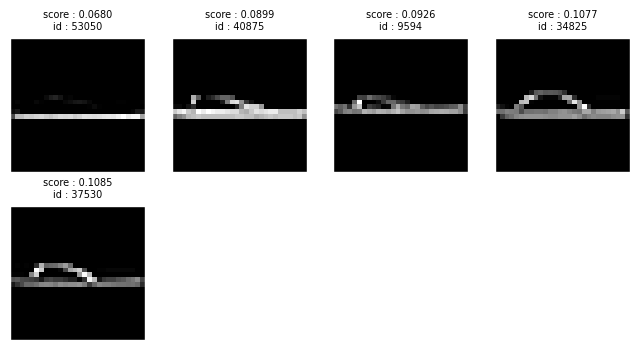

----------------------- dark images ------------------------

Number of examples with this issue: 16
Examples representing most severe instances of this issue:



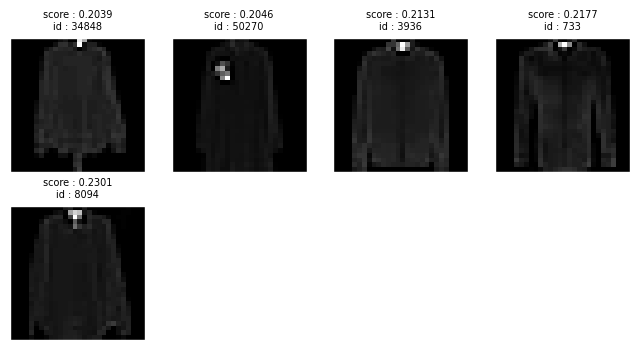

In [58]:
lab.report()

In [59]:
label_issues = lab.get_issues("label")
label_issues.head()

,is_label_issue,label_score,given_label,predicted_label
0,True,1.492955e-05,T - shirt / top,Sandal
1,True,1.979579e-03,T - shirt / top,Dress
2,False,8.449965e-01,Sandal,Sandal
3,True,2.162806e-08,Sandal,T - shirt / top
4,True,3.394909e-04,Dress,Pullover


In [60]:
label_issues_df = label_issues.query("is_label_issue").sort_values("label_score")
label_issues_df.head()

,is_label_issue,label_score,given_label,predicted_label
30197,True,2.380448e-14,Ankle boot,Bag
38621,True,4.190632e-14,Coat,Sandal
34700,True,8.391206e-14,Ankle boot,Bag
21168,True,9.771228e-14,Dress,Sandal
30852,True,1.463209e-13,Sneaker,T - shirt / top


In [61]:
def plot_label_issue_examples(label_issues_df, num_examples=15):
    ncols = 5
    nrows = int(math.ceil(num_examples / ncols))

    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()
    label_issue_indices = label_issues_df.index.values

    for i, ax in enumerate(axes_list):
        if i >= num_examples:
            ax.axis("off")
            continue
        idx = int(label_issue_indices[i])
        row = label_issues.loc[idx]
        ax.set_title(
            f"id: {idx}\n GL: {row.given_label}\n SL: {row.predicted_label}",
            fontdict={"fontsize": 8},
        )
        ax.imshow(dataset[idx]["image"], cmap="gray")
        ax.axis("off")
    plt.subplots_adjust(hspace=0.7)
    plt.show()

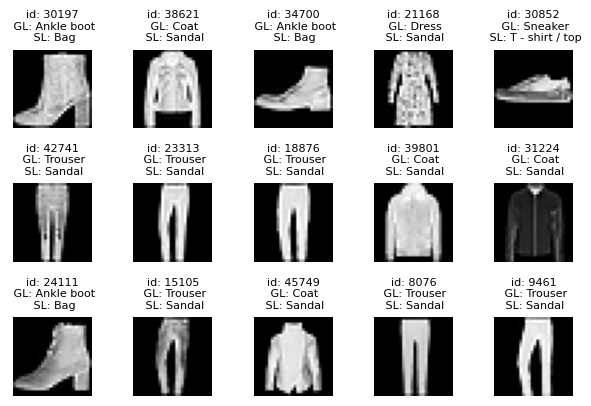

In [62]:
plot_label_issue_examples(label_issues_df, num_examples=15)

In [63]:
outlier_issues_df = lab.get_issues("outlier")
outlier_issues_df = outlier_issues_df.query("is_outlier_issue").sort_values("outlier_score")
outlier_issues_df.head()

,is_outlier_issue,outlier_score
53518,True,0.724592
27526,True,0.733377
54814,True,0.734741
28458,True,0.739921
22938,True,0.746642


In [64]:
def plot_outlier_issues_examples(outlier_issues_df, num_examples):
    ncols = 4
    nrows = num_examples
    N_comparison_images = ncols - 1

    def sample_from_class(label, number_of_samples, index):
        index = int(index)

        non_outlier_indices = (
            label_issues.join(outlier_issues_df)
            .query("given_label == @label and is_outlier_issue.isnull()")
            .index
        )
        non_outlier_indices_excluding_current = non_outlier_indices[non_outlier_indices != index]

        sampled_indices = np.random.choice(
            non_outlier_indices_excluding_current, number_of_samples, replace=False
        )

        label_scores_of_sampled = label_issues.loc[sampled_indices]["label_score"]

        top_score_indices = np.argsort(label_scores_of_sampled.values)[::-1][:N_comparison_images]

        top_label_indices = sampled_indices[top_score_indices]

        sampled_images = [dataset[int(i)]["image"] for i in top_label_indices]

        return sampled_images

    def get_image_given_label_and_samples(idx):
        image_from_dataset = dataset[idx]["image"]
        corresponding_label = label_issues.loc[idx]["given_label"]
        comparison_images = sample_from_class(corresponding_label, 30, idx)[:N_comparison_images]

        return image_from_dataset, corresponding_label, comparison_images

    count = 0
    images_to_plot = []
    labels = []
    idlist = []
    for idx, row in outlier_issues_df.iterrows():
        idx = row.name
        image, label, comparison_images = get_image_given_label_and_samples(idx)
        labels.append(label)
        idlist.append(idx)
        images_to_plot.append(image)
        images_to_plot.extend(comparison_images)
        count += 1
        if count >= nrows:
            break

    ncols = 1 + N_comparison_images
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()
    for i, ax in enumerate(axes_list):
        if i % ncols == 0:
            ax.set_title(
                f"id: {idlist[i // ncols]}\n GL: {labels[i // ncols]}", fontdict={"fontsize": 8}
            )
        ax.imshow(images_to_plot[i], cmap="gray")
        ax.axis("off")
    plt.subplots_adjust(hspace=0.7)
    plt.show()

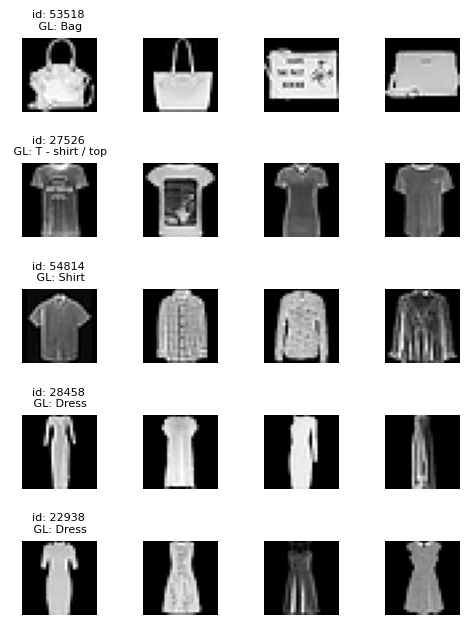

In [65]:
plot_outlier_issues_examples(outlier_issues_df, num_examples=5)

In [66]:
near_duplicate_issues_df = lab.get_issues("near_duplicate")
near_duplicate_issues_df = near_duplicate_issues_df.query("is_near_duplicate_issue").sort_values(
    "near_duplicate_score"
)
near_duplicate_issues_df.head()

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
41151,True,0.000018,[35893],0.000018
35893,True,0.000018,[41151],0.000018
2249,True,0.000025,[30741],0.000025
30741,True,0.000025,[2249],0.000025
81,True,0.000032,"[3231, 58281, 35653]",0.000032


In [67]:
def plot_near_duplicate_issue_examples(near_duplicate_issues_df, num_examples=3):
    nrows = num_examples
    seen_id_pairs = set()

    def get_image_and_given_label_and_predicted_label(idx):
        image = dataset[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        return image, label, predicted_label

    count = 0
    for idx, row in near_duplicate_issues_df.iterrows():
        image, label, predicted_label = get_image_and_given_label_and_predicted_label(idx)
        duplicate_images = row.near_duplicate_sets
        nd_set = set([int(i) for i in duplicate_images])
        nd_set.add(int(idx))

        if nd_set & seen_id_pairs:
            continue

        _, axes = plt.subplots(1, len(nd_set), figsize=(len(nd_set), 3))
        for i, ax in zip(list(nd_set), axes):
            label = label_issues.loc[i]["given_label"]
            ax.set_title(f"id: {i}\n GL: {label}", fontdict={"fontsize": 8})
            ax.imshow(dataset[i]["image"], cmap="gray")
            ax.axis("off")
        seen_id_pairs.update(nd_set)
        count += 1
        if count >= nrows:
            break

    plt.show()

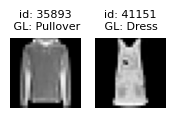

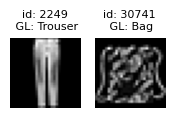

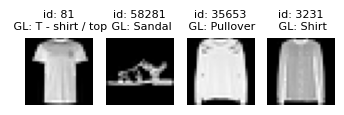

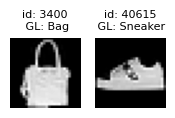

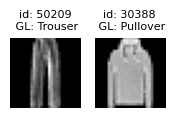

In [68]:
plot_near_duplicate_issue_examples(near_duplicate_issues_df, num_examples=5)

In [69]:
dark_issues = lab.get_issues("dark")
dark_issues_df = dark_issues.query("is_dark_issue").sort_values("dark_score")
dark_issues_df.head()

,dark_score,is_dark_issue
34848,0.203922,True
50270,0.204588,True
3936,0.213098,True
733,0.217686,True
8094,0.230118,True


In [70]:
def plot_image_issue_examples(issues_df, num_examples=15):
    ncols = 5
    nrows = int(math.ceil(num_examples / ncols))

    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()
    issue_indices = issues_df.index.values

    for i, ax in enumerate(axes_list):
        if i >= num_examples:
            ax.axis("off")
            continue
        idx = int(issue_indices[i])
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        ax.set_title(
            f"id: {idx}\n GL: {label}\n SL: {predicted_label}",
            fontdict={"fontsize": 8},
        )
        ax.imshow(dataset[idx]["image"], cmap="gray")
        ax.axis("off")

    plt.subplots_adjust(hspace=0.7)
    plt.show()

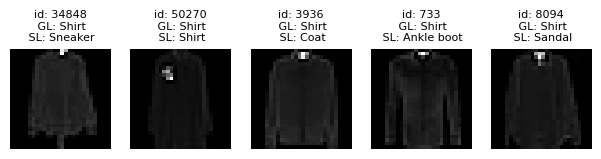

In [71]:
plot_image_issue_examples(dark_issues_df, num_examples=5)

In [72]:
lowinfo_issues = lab.get_issues("low_information")
lowinfo_issues_df = lowinfo_issues.query("is_low_information_issue").sort_values(
    "low_information_score"
)
lowinfo_issues_df.head()

,is_low_information_issue,low_information_score
53050,True,0.067975
40875,True,0.089929
9594,True,0.092601
34825,True,0.107744
37530,True,0.108516


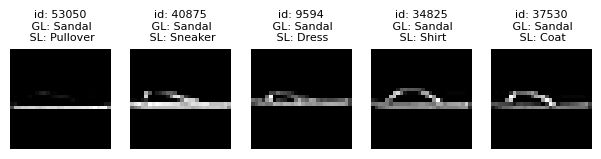

In [73]:
plot_image_issue_examples(lowinfo_issues_df, num_examples=5)